# 通过推特好友预测关注的热门话题
## 前言
最近找实习和找工作的过程中遇到不少岗位都要求有“用户画像”的基础，趁着暑期有点时间，试着学习一下相关知识并且做一个相关的项目来练练手，下面记录一下整个过程。

“用户画像”(User Profile)，即用户信息标签化，是基于数据挖掘的用户特征提取及需求深度挖掘，是大数据时代围绕“以用户为中心”开展的个性化服务，标签化的模型是从用户社交属性、生活习惯、消费者行为等信息中抽象出来的产物，是用户“特征标签”的集合(引自知乎百科)。我的理解是，用一个向量来量化表示一个人，这个向量包含了我们关心的若干个特征，而这些特征可以与这个人的一些行为密切相关。就像游戏里经常用属性六边形来描述一个人的战斗力一样，我们选取出与战斗最相关的六个特征，比如攻击、防御、敏捷等，再在每个特征维度上用数字来量化，从而精确的描绘出一个人的战斗力，并且在不同个体之间还可以进行比较。那么对于一个用户，我们该用什么特征来对其进行描述呢？这其实得看我们关心用户的哪些行为，如果关心的是用户的投资行为，那么其收入能力、资产价值、风险偏好等可能是更好的特征；如果是关心用户对那些内容更感兴趣，那么其以往的浏览历史，其关注的作者，以及其显性的收藏和喜爱是更好的特征。明确对用户的哪些行为感兴趣，选定可能合适的一些特征之后，就可以按照一定的规则量化的表示出这些特征。但量化的表示出一个用户并不是目的，最终目的肯定是通过这些量化的特征来预测用户的行为。

如何进行预测呢？答案从以往的大数据来。我们可以首先凭直觉选定一些可能的特征，或者选取从已有的大数据中观察到的一些特征，建立对目标行为的预测模型，然后用一部分数据来验证我们的模型是否正确。从选定特征到验证模型分两步，第一步是用一部分数据来建立预测模型，也就是确定这些特征变量里哪些更重要，哪些不重要，哪些变量之间如何相互作用。比如用户的投资行为，收入能力、资产价值、风险偏好都会影响用户投资不同理财产品的资金量，但是这三个因素中哪一个影响最大，这就需要用已有的数据来确定。第二部是验证我们的模型，就是把另一部分数据代入到我们的模型中，看我们预测的结果和真实的结果相差大不大，如果差距在我们能容忍的范围内，就说明我们的模型可以接受。

## 项目介绍

本项目的数据是Kaggle上的[Twitter Friends](https://www.kaggle.com/hwassner/TwitterFriends)数据集，共有10列变量，40000条记录。40000条记录我不清楚算多还是算少，反正相比我之前在实验室处理过的数据应该算多的。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
data = pd.read_csv("./data.csv", sep = ',(?=\S)', engine = 'python')
data.head()

,id,screenName,tags,avatar,followersCount,friendsCount,lang,lastSeen,tweetId,friends
0,"""1969527638""","""LlngoMakeEmCum_""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/534286217...",319,112,"""en""",1472271687519,"""769310701580083200""","[ ""1969574754"", ""1969295556"", ""1969284056"", ""1..."
1,"""51878493""","""_notmichelle""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/761977602...",275,115,"""en""",1472270622663,"""769309490038439936""","[ ""60789485"", ""2420931980"", ""2899776756"", ""127..."
2,"""1393409100""","""jesseayye""","[ ""#narcos"" ]","""http://pbs.twimg.com/profile_images/713282938...",120,107,"""en""",1472804144409,"""771622623583186944""","[ ""86868062"", ""19697415"", ""2998836604"", ""45629..."
3,"""232891415""","""MrBrianLloyd""","[ ""#gloryoutnow"" ]","""http://pbs.twimg.com/profile_images/133440668...",492,325,"""en""",1472269186776,"""769308131696467969""","[ ""361335082"", ""1405248468"", ""24626354"", ""7256..."
4,"""710130422907207680""","""sarahdorat_16""","[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/767180520...",128,218,"""en""",1472271397356,"""769309769144283137""","[ ""1571896093"", ""768938323612008448"", ""2548665..."


上表中展示了部分数据，下面详细描述一下每个变量分别是什么含义。

* id：用户id，每个用户一个，独一无二，这里40000条记录的id没有重复，也就是这40000条记录代表40000个用户的数据记录；
* screenName：用户名；
* tags：用户发布的热门话题("trending topic")，是一个列表，里面包含一个或多个话题；
* avatar：用户头像的图片链接；
* followersCount：关注当前用户的人的数量；
* friendsCount：当前用户关注的人的数量；
* lang：当前用户使用的语言；
* lastSeen：该用户最后登陆时间的时间戳；
* tweetId：该用户发的最后一条推特的id；
* friends：当前用户关注的人的用户id，是一个列表，里面有多个或零个推特用户id。

俗话说“物以类聚，人以群分”，人们会因为志趣相投从而结交成为好友。反过来思考，能成为好友的人，很大可能也是拥有共同兴趣爱好的人。再换句话说，两个人的朋友圈越接近，这两个人的兴趣爱好也越可能相同。所以本项目的基本假设就是，一个人的兴趣话题和其关注的人存在着一定的关系，我们可以从一个人关注的人来推测其感兴趣的话题。因此，本项目最关注的变量是**id**，**tags**，**friends**。

## 项目实施

首先对数据集进行基本的描述，重点是对我们最关注的变量进行描述。

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              40000 non-null  object
 1   screenName      40000 non-null  object
 2   tags            40000 non-null  object
 3   avatar          40000 non-null  object
 4   followersCount  40000 non-null  int64 
 5   friendsCount    40000 non-null  int64 
 6   lang            40000 non-null  object
 7   lastSeen        40000 non-null  int64 
 8   tweetId         40000 non-null  object
 9   friends         40000 non-null  object
dtypes: int64(3), object(7)
memory usage: 3.1+ MB


In [4]:
pd.DataFrame({'col':data.columns, 'types':list(map(type, data.iloc[0]))})

,col,types
0,id,<class 'str'>
1,screenName,<class 'str'>
2,tags,<class 'str'>
3,avatar,<class 'str'>
4,followersCount,<class 'numpy.int64'>
5,friendsCount,<class 'numpy.int64'>
6,lang,<class 'str'>
7,lastSeen,<class 'numpy.int64'>
8,tweetId,<class 'str'>
9,friends,<class 'str'>


可以看到，**tags**和**friends**本应是列表现在读入时却被认为是'str'，所以我们首先对这两个变量进行一下处理。

In [5]:
for col in ['tags', 'friends']:
    data[col] = data[col].apply(json.loads) #将这两列由str变为list
pd.DataFrame({'col':data[['tags', 'friends']].columns, 'types':list(map(type, data[['tags', 'friends']].iloc[0]))})

,col,types
0,tags,<class 'list'>
1,friends,<class 'list'>


In [6]:
data.describe()

,followersCount,friendsCount,lastSeen
count,4.000000e+04,40000.000000,4.000000e+04
mean,3.692349e+03,919.101450,1.472287e+12
std,9.136179e+04,3417.849318,1.010296e+08
min,1.010000e+02,101.000000,1.472249e+12
25%,2.420000e+02,253.000000,1.472259e+12
50%,4.400000e+02,423.000000,1.472265e+12
75%,9.240000e+02,801.000000,1.472270e+12
max,1.476555e+07,238749.000000,1.472808e+12


接下来重点看**tags**和**friends**两个变量。

In [7]:
all_possible_tags = [tag for tag_list in data['tags'] for tag in tag_list ]
print('所有可能的热门话题的数量为 %d 个。' % len(set(all_possible_tags)))

所有可能的热门话题的数量为 128 个。


<AxesSubplot:ylabel='tags'>

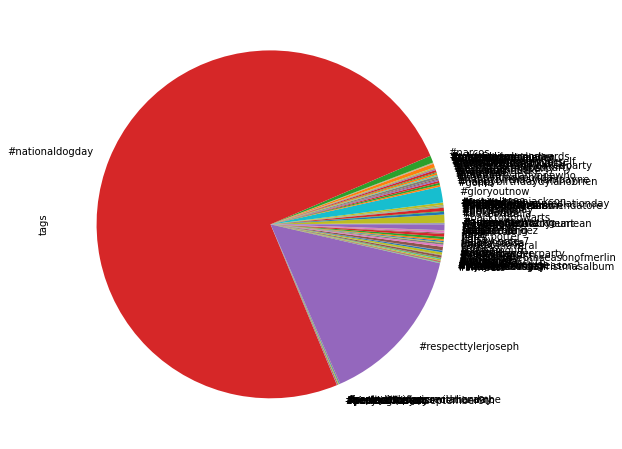

In [8]:
pd.DataFrame({'tags':all_possible_tags}).\
    groupby(['tags']).\
    agg({'tags':'count'}).\
    plot.pie(y = 'tags', figsize = (10,8), legend = False)

可以看到，**tags**的比例非常不均匀，绝大多数用户的热门话题都是"#nationaldogday"(74.8%)和"#respecttylerjoseph"(14.8%)，而其他所有热门话题加起来只占剩下的10.4%。

In [9]:
all_possible_ids = [id for id_list in data['friends'] for id in id_list ]
print('该数据集中所有可能用户id的数量为 %d 个。' % len(set(all_possible_ids)|set(data['id'])))

该数据集中所有可能用户id的数量为 12917532 个。


可以看到，仅仅40000条记录，其中包含的所有可能的用户id却是惊人的多。

### 方案一

基于最朴素的想法，两个人朋友圈越重合，即两个人关注的对象越重合，那么这两个人的兴趣应该也会越像。朋友圈的重合度可以用集合的相似性$J(A,B)={|A \bigcap B|\over |A \bigcup B|}$ 的公式来计算。 我们将数据集分成训练集(20%)和测试集(80%)两个部分，对于测试集中的每一个"新"用户，我们在训练集中找出与其朋友圈最相似的"老"用户，并用该"老"用户对应的热门话题作为我们对这个"新"用户感兴趣话题的预测结果。这个方案里，看上去似乎并没有建模这一步，这是因为这里我们只有一个特征，就是**friends**变量所代表的用户所关注的人，所以可以不需要筛选特征这一步骤。其次，**friends**作为离散变量，如果要进行向量化的话应该是用独热编码，但是这里可能的用户id数量有一千万个，进行独热编码不太现实，而且编码后的矩阵肯定很稀疏(大部分都是0)。因此，这里并没有采用进一步的编码和处理，直接用这一个集合作为刻画该用户的特征。最后是在训练集内建立好模型，这里我的模型似乎是有点牵强，就是简单的寻找计算两个用户之间朋友圈的重合度，然后取最大值，但是要想在训练集中说明这个模型的合理性也不是不可以。我们先计算训练集内两两用户之间朋友圈的重合度，这样应该得到32000×32000的数值矩阵A，然后同样用计算集合间相似度的公式计算两两用户之间热门话题的重合度，这样也能得到32000×32000的数值矩阵B(不过大部分都是0和1，因为大部分人只关注一个热门话题，要么一样，要么不一样）。用矩阵B的0值mask取出矩阵A中所有值算出平均值\alpha，用矩阵B的非0值mask取出矩阵A中所有值算出平均值\beta，应有\beta显著高于\alpha。在训练集内验证完之后，就可以用这个模型去预测测试集中用户感兴趣的热门话题，通过看预测的正确率来评判模型。

这个方案我倒在了在测试集内计算两两用户之间朋友圈的重合度，这一步需要的内存太大了。无数次因为内存溢出而程序终止。

由于样本量太大，一是计算起来特别慢，第二个是内存占用太大。也想过降低精度，或者一次只计算一对用户的相似性，但是发现这效率仍然不理想。尤其是假设放在应用场景中，用户数量甚至不止40000个，要想遍历所有的用户然后找出最相似的朋友圈，根本不现实，最后放弃了这个方案。

### 方案二

方案一的失败究其原因我觉得是我选的特征不对，以用户关注的用户集合(即朋友圈)作为特征，一是因为用户id过多而无法进行编码，只能保持列表的形式，导致后续内存占用大计算速度慢。二是这个特征变动太大，没新增一个用户，这个特征的复杂度就会提高一点。所以方案二我直接换了一个特征，换成了**tags**。因为在之前的探索中，我们发现所有可能的tag只有128种，从现实应用考虑，热门话题或者说兴趣的门类都是相对固定的，变动没有那么大，所以用这个作为特征来描绘一个用户是比较好的。对**tags**进行独热编码，最后将是每一个用户对应一个长度为128的01向量。这样，我们对测试集进行编码，将会得到一个32000*128的表。

那么问题来了，我们的目标是通过一个人的朋友圈来预测这个人可能感兴趣的话题，现在我们对**tags**是进行编码了，那朋友圈这个变量在哪里体现呢？这个体现在后续的模型里：![方案二示意图](./方案二示意图.png)


我们以待预测用户的**friends**为索引去测试集中找到相应的**tags**向量，然后将所有的向量加权求和，最后找到最大值所对应的tag，即是我们最终的预测结果。

整个模型的代码如下：

In [10]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size = 0.2)

In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
# 把tags转化为01编码的向量
onehot_tags = pd.DataFrame(mlb.fit_transform(train_data['tags']), columns=mlb.classes_, index=train_data.index)
tags_of_person = train_data[['id']].join(onehot_tags)
del onehot_tags
# 把friends从一个包含多个id的列表，变成多行的字符串，每一行只包含一个id
friends_of_person = train_data[['id','friends']].explode('friends')

In [12]:
def predict_by_friends(friends, known_tags, known_friends):
    direct_friends_tags = pd.DataFrame({'friends':friends}, dtype = 'string').\
    merge(known_tags, left_on = 'friends', right_on = 'id')
    if not direct_friends_tags is None:
        direct_prediction = direct_friends_tags.astype({'friends':'string'}).sum(axis = 0)
    else:
        direct_prediction = None
    indirect_friends = pd.DataFrame({'friends':friends}).merge(known_friends, on = 'friends')
    if not indirect_friends is None:
        indirect_prediction = indirect_friends.merge(known_tags, on = 'id').\
        astype({'friends':'string'}).\
        sum(axis = 0)
    else:
        indirect_prediction = None
    if direct_prediction is None and indirect_prediction is None:
        return ""
    elif direct_prediction is None:
        return indirect_prediction.idxmax()
    elif indirect_prediction is None:
        return direct_prediction.idxmax()
    else :
        return (direct_prediction + indirect_prediction*0.5).idxmax()

如果只对少量人进行预测，比如10个人大概需要两分钟的样子，但对整个测试集的8000人进行预测，需要跑大概21个小时(在本地跑，CPU：Intel i7，内存：2×8G)。所以这里不进行实时测评，而是将结果先保存下来再进行后续预测效果的测评。

In [13]:
test_data = pd.read_pickle("./res_prediction.pkl")
test_data.head()

,id,screenName,tags,followersCount,friendsCount,lastSeen,friends,predict_tags,is_correct
12003,"""2536373540""","""0932824_""",[#gloryoutnow],176,422,1472256379640,"[373471064, 450186253, 108775893, 78177660, 76...",#nationaldogday,False
23734,"""2205782736""","""Quantum_Zombu""",[#nationaldogday],109,246,1472262858382,"[3375167474, 21896677, 1676327754, 14645160, 3...",#nationaldogday,True
25887,"""1090515896""","""_zellers""",[#nationaldogday],781,547,1472259401961,"[503331445, 2365044235, 534353064, 768930708, ...",#nationaldogday,True
35612,"""4831473671""","""_VyTran_""",[#nationaldogday],143,199,1472271502230,"[1180655028, 3003647874, 3051005236, 701981266...",#nationaldogday,True
16132,"""1135525494""","""gabixx27""",[#respecttylerjoseph],424,319,1472266916398,"[2437766502, 30892730, 2830720945, 957027824, ...",#respecttylerjoseph,True


注意这里其实相比最开始少了**avatar**，**lang**和**tweetid**这三列，这是因为我最开始的脚本里是把这三列删掉了的，现在文档里并没有这一步删除，但是我也实在不想重跑一遍了。

可以看到预测效果看上去还行，前五个里面对了四个。那么接下来看一下总的正确率。

In [14]:
rate_correct = sum(test_data.is_correct)/len(test_data.is_correct)
print('总预测正确率为 %.2f %%.' % (rate_correct*100))

总预测正确率为 85.29 %.


总预测正确率达到85.29%，看上去效果不错，但是从一开始我们就看到，tags的分布比例是非常不均匀的，有74.8%的"#nationaldogday"，也就是说，假如我们一股脑的全部都预测为"#nationaldogday“，我们也有74.8%的正确率，但这个预测就毫无意义了。为了排除这种可能，即正确率高仅仅是因为预测结果中tag分布不均匀，我们对预测结果进行随机打乱，这样各个tag的数量和比例保持不变，变化的是预测结果是否与预测对象正确对应。

随机打乱一千次，看一下随机水平下，预测正确率会是多高。

<AxesSubplot:ylabel='Frequency'>

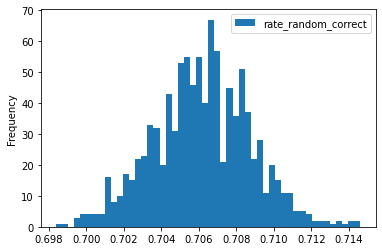

In [15]:
import random

rate_random_correct = []
random_predict_tags = list(test_data.predict_tags.copy())
for i in range(1000):
    random.shuffle(random_predict_tags)
    rate_random_correct.append(sum(list(map(lambda x, y: x in y, random_predict_tags, test_data['tags'])))/len(test_data['tags']))
    
pd.DataFrame({'rate_random_correct':rate_random_correct}).\
    plot.hist(bins = 50)

In [16]:
print('随机水平下，预测正确率平均值为 %.2f %%, 预测正确率最大值为 %.2f %%.' % (sum(rate_random_correct)/len(rate_random_correct)*100, max(rate_random_correct)*100))

随机水平下，预测正确率平均值为 70.62 %, 预测正确率最大值为 71.46 %.


可以看到，我们的模型的正确率远高于随机水平，说明我们的模型确实具有一定的预测效果。

## 总结与反思

这是我第一次尝试做用户画像，毕竟没有人可以请教，完全是凭感觉做的，所以有点粗糙。甚至我都不知道我这个能不能算用户画像，还是就是一个天马行空的预测模型。虽然最后确实有一定的预测效果，这个预测模型算是成功了，但是总觉得这个模型和我想象中的用户画像不太一样。按我的理解，用户画像是能够用一个向量把这个用户的量化，标签化，之后就可以根据这个向量来预测这个用户的行为。按照这个标准，我这里的用户画像应该是倒数第二步把直接tag和间接tag加权求和之后的向量，但这个太过于依赖于训练集，也就是已有数据库里面的数据，跟我想的可以相对独立的从一个用户自己的行为数据抽象出一些指标形成一个向量不太一样。所以我不知道这算不算用户画像。

另外一个问题就是，这个预测模型太过草率，直接tag和间接tag加权求和的权重完全是我一拍脑门，觉得直接tag是“朋友的tag”，更可靠，权重应该高一点；间接tag是“朋友的朋友的tag”，有一层推断在，更没那么靠谱，权重应该低一点，所以一个设为1一个设为0.5。这个权重最靠谱的应该是用训练集的数据来进行机器学习得到，甚至不同tag的权重也可以不同(现在是认为等同，全为1)，因为可能有些话题更具有煽动性和群体性，所以两个朋友之间更可能共享话题，而有些话题本身不具有煽动性和群体性，即使两个人是朋友也不一定要共享这个话题。比如一个全国性的“建党100周年”话题和一个湖南省内的“烟花节”，显然前者这个话题的“传递性”更强，“传递范围”更广。但仅仅是对测试机8000个人进行预测就花了接近一天的时间，如果要对训练集32000个人来进行机器学习，那我这台小电脑可能会有一段时间做不了其他事情了，万一导师有活儿可咋办？后面还有机会的话，倒是可以沿着这条思路继续做一下。

假设继续用当前这个预测模型，还有哪里可以优化呢？一是不同人的**friends**数量差异太大，有人的**friends**多达238749个，真正找出这么多人的直接tag或者间接tag是不划算的，所以可以考虑随机采样，对**friends**数量少于1000人的，全部**friends**都纳入计算，对**friends**多于1000人的，随机采样1000个人，这样可以大大减少计算负担，也减少内存的占用。二是数据精度的要求可以降低，在采取了第一条的措施之后，1000个人的tag求和最多也就到1000，这样的话np.int16就够用了，而目前是int32，还可以再节省一半的内存。

In [17]:
max(data.friendsCount)

238749